# Import some tools


In [1]:
research_directory = '/Users/liutianlin/Desktop/Academics/MINDS/OOM/tom/research'
tools_script = research_directory + '/Tools.ipynb' # import the tools
%run $tools_script
import random
import scipy as sp
import scipy.sparse

random.seed(1234)
np.random.seed(1234)
rand = tom.Random(1234)


class MissingRelevance(tom.stree.PositionRelevance):
    def __init__(self, missingFactor = 0, notMissingFactor = 1):
        self.missingFactor = missingFactor
        self.notMissingFactor = notMissingFactor
        super().__init__()
    def compute(self, position):
        seq = position.sequence()
        nMissing = seq.inputSum()
        nNotMissing = seq.length() - nMissing
        return super().compute(position) * self.missingFactor**nMissing * self.notMissingFactor**nNotMissing
def o_min(l, Σₒ, Σᵢ): # effective word length
    Σᵢ = max(1, Σᵢ)
    Σ = Σₒ * Σᵢ
    l = np.log(l) / (np.log(Σ) + np.log(Σᵢ))
    return (l+1) * Σᵢ**l

def genRingHMM(nStates, nObservations):
    hmm = tom.hmm.Hmm(nStates, nObservations)
    diagonals = [np.random.uniform(0,1,nStates), np.random.uniform(0,1,nStates-1), np.random.uniform(0,1,nStates-1)]
    Tpre = np.array(scipy.sparse.diags(diagonals, [0, -1, 1]).todense())
    Tpre[0,nStates-1] =np.random.uniform(0,1)
    Tpre[nStates-1,0] = np.random.uniform(0,1)
    rowSums = Tpre.sum(axis=1)
    T = Tpre / rowSums[:, np.newaxis] # normalize the (hidden-states) transition matrix
    hmm.T(T)    
    
    observationMatrix = np.zeros((nStates,2)) # Each state has at most 2 possible observations, chosen at random.
    for countState in range(0, nStates): 
        observationMatrix[countState,0] = np.random.randint(0, nObservations)
        observationMatrix[countState,1] = np.random.randint(0, nObservations)

    for countObservation in range(0, nObservations):
        statesEmitObs = np.where(observationMatrix == countObservation)[0] # states that emmit the observation 
        diagPre = np.zeros(nStates)
        for i in statesEmitObs:
            diagPre[i] = np.random.rand()
    
        if sum(diagPre) == 0:
            diag = np.zeros(nStates)
        else:
            diag = diagPre / (sum(diagPre))
        diag = np.array([[x] for x in diag],dtype=float)
        hmm.E(countObservation, diag)    

    pi = np.random.uniform(0,1,nStates)
    pi = np.array([[x] for x in pi],dtype=float)
    hmm.pi(pi)
    hmm.init()
    
    return hmm


# Create a Ring-HMM and convert it to an OOM
We generate a ring-topology HMM with 20 states and 20 observations. Each state has at most 2 possible observations, chosen at random. The transition matrix follows a ring topology, where each state can only transition to its two neighbors or to itself. All non-zero entries of the transition matrix, the emission matrix, and the initial state distribution are picked uniformly randomly from [0, 1) and then normalized. 

In [2]:
nStates = 20
nObservations = 20
#ID = 0
nOextra = 1
nU = 1

ringHMM = genRingHMM(nStates, nObservations)
columnE = ringHMM.E(0);
for i in range(1, nObservations):
    columnE = np.hstack((columnE,ringHMM.E(i)))

ringOOM = tom.hmm.convert_HMM_to_OOM(ringHMM.T(), columnE, np.concatenate(ringHMM.pi(),axis=0 )) # convert the hmm to oom
trueSeq = ringOOM.sample(100000, rand) # genearte a sequence of symbols





# Esemble the training data
First sample the trajectory without missing values and then corrupt it into the sequence with missing values 

In [3]:
ringTopologyPath = '/Users/liutianlin/Desktop/Academics/MATLAB/missingValueCode/Data/ringTopology/'
os.chdir(ringTopologyPath)

trainDataDict = {'mild': float('nan')} # initialize the dictionary of training trajectories

for missingness in ['mild', 'severe']:

    # write the sequence of symbols as input-output pairs
    mSeq = tom.Sequence(trueSeq.length(), trueSeq.nOutputSymbols() + nOextra, nU)
    for t in range(mSeq.length()):
        mSeq.u(t, 0); mSeq.o(t, trueSeq[t])

    noMissingSeq = mSeq[:]


    if missingness == 'severe':
        missingForecaster = random.sample(range(0, nObservations), 10) # randomly sample a set of "missingness Forecaster"
        missingRateAfterForecaster = 0.5; # prob of missingness after the missingness Forecaster
       
    else:
        missingForecaster = random.sample(range(0, nObservations), 5) # randomly sample a set of "missingness Forecaster"
        missingRateAfterForecaster = 0.3; # prob of missingness after the missingness Forecaster
        
    mSeq = noMissingSeq[:]    
    for t in range(noMissingSeq.length()-1):
        if noMissingSeq.o(t) in missingForecaster: # if output is in the missingness forcaster set
            if np.random.rand() < missingRateAfterForecaster:
                mSeq.u(t+1, 1)
                mSeq.o(t+1, mSeq.nOutputSymbols())        
    
    
    #train = mSeq     
    trainDataDict[missingness] = mSeq


    # use '#' to denote a missing value
    mSeqList = [0] * mSeq.length()
    for t in range(mSeq.length()):
        if mSeq.u(t) == 0:
            mSeqList[t] = chr(int(mSeq.o(t)+97))
        else:
            mSeqList[t] = '#'

    print(mSeqList.count('#'))
    trainFile = 'HMM_ringTopology_train_' + missingness + '.txt'

    text_file = open(trainFile, "w")
    text_file.write("%s \n" % ''.join(e for e in mSeqList) )
    text_file.close()        

8523
21244


In [4]:
mSeq.length()

100000

# Sample the testing data

In [5]:
test_sequences = []
for i in range(10000):
    ringOOM.reset()
    test_sequences.append(ringOOM.sample(100, rand))
    #test_sequences.append(ringOOM.sample(10, rand))
    
    


# Learning with missing values

In [6]:
data = tom.Data() # Initialize a tom.Data object
dim = nStates # the dim is just the nr of states of the HMM
wordSetting = (0, 0, 'o_min(tl,Σₒ+1,1)', 1024, False, False, 'MissingRelevance((Σₒ)**-1,1)') # instantiate the wordsetting
wildcard = True # instantiate the wildcard setting
regularization = (2,'3/tl**2') #???
stabilization=(0.0002, 0.03, 5, 1e-8) #???
Σₒ = nObservations # number of observations
regular = True # use regular spectral learning algorithm (without weights)
trainLengths = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000];
       
resultDict = {}
    

In [7]:
for missingness in ['mild', 'severe']:
    train = trainDataDict[missingness]

    learnt_ooms = []        
    for tl in trainLengths:
        # 1. Use the current training sequence to obtain estimates
        data.sequence = train.sub(tl) 

        # 2. Set the number of input   
        data.nInputSymbols = 1


        # 3. Set for regularization               
        reg = [] # ???
        for i in regularization: # Note: Cannot use list comprehension due to `eval` here!
            reg.append(eval(i) if type(i) is str else i)
        data.regularization = reg

        # 4. Set for words       
        wS = [] 
        for i in wordSetting:
            wS.append(eval(i) if type(i) is str else i)
    
        # 5. Select sets of indicative and characteristic words:
        data.X = wS # ???
        data.Y = data.X # ???
    
        # 6. Select the estimator
        data._estimator = tom.EstimatorMCAR(data.stree) if wildcard else tom.Estimator(data.stree)
    
        # 7. Perform spectral learning to estimate an IO-OOM:
        data.pre_compute()
        spec, subspace = tom.learn.model_estimate(data, dim, method='SPEC', return_subspace=True)
    
        # 8. convert the IO-OOM to the OOM
        spec.setIO(False) # convert to normal OOM
        spec.w0 = spec.stationaryState
        spec.stabilization(*stabilization)
    
        learnt_ooms.append(spec)
        print('.', end='', flush=True)
    

    # 1-step err missing value oom
    proposed_averageOneStepPredictionError = [np.average([learnt_oom.averageOneStepPredictionError(test_sequence, ringOOM) for test_sequence in test_sequences ])
                for learnt_oom in learnt_ooms]
    proposed_l2l = [np.average([learnt_oom.l2l(test_sequence) for test_sequence in test_sequences ])
                for learnt_oom in learnt_ooms]    

    resultDict[missingness + '_proposed_averageOneStepPredictionError']= proposed_averageOneStepPredictionError
    resultDict[missingness + '_proposed_l2l']= proposed_l2l


....................

# Load the baseline results
Baselines (1) missing value HMM (2) short trajectory HMM (3) short trajectory OOM

In [8]:
import scipy.io as sio

for missingness in ['mild', 'severe']:
    loadFileName = '/Users/liutianlin/Desktop/Academics/MATLAB/missingValueCode/ringHMM_params_' + missingness + '.mat'
    mat_contents = sio.loadmat(loadFileName)


    mis_HMM_params = list(mat_contents['mis_HMM_params'])
    short_traj_HMM_params = list(mat_contents['short_traj_HMM_params'])
    short_traj_OOM_params = list(mat_contents['short_traj_OOM_params'])

    trans_mis_hmms = []
    short_traj_hmms = []
    short_traj_ooms = []


    for i in range(len(trainLengths)):
        trans_mis_hmm = tom.hmm.Hmm(nStates, nObservations)
        trans_mis_hmm.T(mis_HMM_params[0][i][0][0]) # the state transition matrix
        pi = np.array([[i] for i in mis_HMM_params[0][i][0][2][0]]) # the belief
        trans_mis_hmm.pi(pi)
        EMat = mis_HMM_params[0][i][0][1] # the emission matrix
    

        trans_mis_hmm = tom.hmm.convert_HMM_to_OOM(trans_mis_hmm.T(), EMat, np.concatenate(trans_mis_hmm.pi(),axis=0 )) # convert the hmm to oom
        #trans_mis_hmm.stabilization(*stabilization)
        #trans_mis_hmm.w0 = trans_mis_hmm.stationaryState
        trans_mis_hmms.append(trans_mis_hmm)
    
    
    
        ##
        short_traj_hmm = tom.hmm.Hmm(nStates, nObservations)
        short_traj_hmm.T(short_traj_HMM_params[0][i][0][0]) # the state transition matrix
        pi = np.array([[i] for i in short_traj_HMM_params[0][i][0][2][0]]) # the belief
        short_traj_hmm.pi(pi)
        EMat = short_traj_HMM_params[0][i][0][1] # the emission matrix
    

        short_traj_hmm = tom.hmm.convert_HMM_to_OOM(short_traj_hmm.T(), EMat, np.concatenate(short_traj_hmm.pi(),axis=0 )) # convert the hmm to oom
        #short_traj_hmm.stabilization(*stabilization)
        #short_traj_hmm.w0 = short_traj_hmm.stationaryState
        short_traj_hmms.append(short_traj_hmm)
    
        ##
        short_traj_oom = tom.Oom(nStates, nObservations) # 20-dimensional OOM with an alphabet size of  20
        short_traj_oom.sig(short_traj_OOM_params[0][i][0][0])
    
    
    
        short_traj_oom.w0(short_traj_OOM_params[0][i][0][2])
                      
        for j in range(nObservations):
            short_traj_oom.tau(j,np.array(short_traj_OOM_params[0][i][0][1][0][j], dtype='float')  )
        
        short_traj_oom.initialize()
        #short_traj_oom.stabilization(*stabilization)        
        #short_traj_oom.w0 = spec.stationaryState

        short_traj_ooms.append(short_traj_oom)
    

        # 1 step prediction error


        
        # 1-step err missing value HMM
        missing_hmm_averageOneStepPredictionError = [np.average([trans_mis_hmm.averageOneStepPredictionError(test_sequence, ringOOM) for test_sequence in test_sequences ])
                   for trans_mis_hmm in trans_mis_hmms]

        # 1-step err short traj HMM

        short_traj_hmm_averageOneStepPredictionError = [np.average([short_traj_hmm.averageOneStepPredictionError(test_sequence, ringOOM) for test_sequence in test_sequences ])
                   for short_traj_hmm in short_traj_hmms]

        # 1-step err short traj oom

        short_traj_oom_averageOneStepPredictionError = [np.average([short_traj_oom.averageOneStepPredictionError(test_sequence, ringOOM) for test_sequence in test_sequences ])
                   for short_traj_oom in short_traj_ooms]


        # aeverage l2l error

        # aeverage l2l missing value hmm
        missing_hmm_l2l = [np.average([trans_mis_hmm.l2l(test_sequence) for test_sequence in test_sequences ])
                   for trans_mis_hmm in trans_mis_hmms]


        # aeverage l2l short traj hmm

        short_traj_hmm_l2l = [np.average([short_traj_hmm.l2l(test_sequence) for test_sequence in test_sequences ])
                   for short_traj_hmm in short_traj_hmms]

        # aeverage l2l short traj oom
        short_traj_oom_l2l = [np.average([short_traj_oom.l2l(test_sequence) for test_sequence in test_sequences ])
                   for short_traj_oom in short_traj_ooms]

        
        resultDict[missingness + '_missing_hmm_averageOneStepPredictionError'] = missing_hmm_averageOneStepPredictionError
        resultDict[missingness + '_short_traj_hmm_averageOneStepPredictionError'] =  short_traj_hmm_averageOneStepPredictionError
        resultDict[missingness + '_short_traj_oom_averageOneStepPredictionError'] = short_traj_oom_averageOneStepPredictionError
        resultDict[missingness + '_missing_hmm_l2l'] = missing_hmm_l2l
        resultDict[missingness + '_short_traj_hmm_l2l'] = short_traj_hmm_l2l
        resultDict[missingness + '_short_traj_oom_l2l'] =  short_traj_oom_l2l

        

In [9]:
resultDict['mild_' + 'short_traj_hmm_l2l']


[26.771991064870534,
 30.270216186705166,
 17.63445843539461,
 12.443716152989504,
 13.346491395352807,
 8.660222090026936,
 8.54660222980708,
 7.781992951006723,
 7.666669737737946,
 9.378780060320915]


# Plot the results

In [1]:
plt.rc('axes', titlesize=8)     # fontsize of the axes title
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels
plt.rc('font', family='serif', serif='Times', weight='bold')
plt.rc('text', usetex=True)

width = 6
height = width / 1.618



fig = plt.figure()
#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

#plt.subplots_adjust(left=.15, bottom= .16, right=0.99, top=0.97, wspace=0.3, hspace=0.5)
#plt.suptitle('RING TOPOLOGY', fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.5)


ax = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(222)
ax4 = fig.add_subplot(224)

ax.plot(np.array(trainLengths), 
            resultDict['mild_' + 'proposed_l2l'], 
            linewidth=2, 
            linestyle='-', 
            marker = 'x',
            markersize=8,
            label='missing value OOM'
           );

ax.plot(np.array(trainLengths), 
        resultDict['mild_' + 'short_traj_oom_l2l'],
        linewidth=2, 
        marker = '4',
        markersize=8,
        linestyle='-.', 
        #label='short trajectory OOM (spectral method)'
       );

ax.plot(np.array(trainLengths),  
        resultDict['mild_' + 'missing_hmm_l2l'],
        linewidth=2, 
        linestyle='--', 
        marker = '2',
        markersize=8,
        #label='missing value HMM (EM method)' 
       );


ax.plot(np.array(trainLengths),  
        resultDict['mild_' + 'short_traj_hmm_l2l'],
        linewidth=2, 
        linestyle=':', 
        marker = '+',
        markersize=8,
        #label='short trajectory HMM (EM method)' 
       );


ax.set_ylabel('ANLL');
#ax.set_xlabel('Length of training data');
ax.set_title('Mild missingness')
ax.set_ylim(0, 18)

#plt.gcf().subplots_adjust(bottom=0.15)
#ax.tick_params(labelsize=35, rotation=0)



ax2.plot(np.array(trainLengths), 
            np.log2(resultDict['mild_' + 'proposed_averageOneStepPredictionError']), 
            linewidth=2, 
            linestyle='-', 
            marker = 'x',
            markersize=8,
            #label='missing value OOM'
           );

ax2.plot(np.array(trainLengths), 
        np.log2(resultDict['mild_' + 'short_traj_oom_averageOneStepPredictionError']), 
        linewidth=2, 
        marker = '4',
        markersize=8,
        linestyle='-.', 
        #label='short trajectory OOM'
       );

ax2.plot(np.array(trainLengths),  
        np.log2(resultDict['mild_' + 'missing_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle='--', 
        marker = '2',
        markersize=8,
        #label='missing value HMM' 
       );


ax2.plot(np.array(trainLengths),  
        np.log2(resultDict['mild_' + 'short_traj_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle=':', 
        marker = '+',
        markersize=8,
        #label='short trajectory HMM' 
       );



ax2.set_ylabel('LAOSPE');
ax2.set_xlabel('Length of training data');
ax2.set_ylim(-13, -4)
ax2.set_title('Mild missingness')







######

ax3.plot(np.array(trainLengths), 
            resultDict['severe_' + 'proposed_l2l'], 
            linewidth=2, 
            linestyle='-', 
            marker = 'x',
            markersize=8,
            label='missing value OOM'
           );

ax3.plot(np.array(trainLengths), 
        resultDict['severe_' + 'short_traj_oom_l2l'],
        linewidth=2, 
        marker = '4',
        markersize=8,
        linestyle='-.', 
        label='short trajectory OOM'
       );

ax3.plot(np.array(trainLengths),  
        resultDict['severe_' + 'missing_hmm_l2l'],
        linewidth=2, 
        linestyle='--', 
        marker = '2',
        markersize=8,
        label='missing value HMM' 
       );


ax3.plot(np.array(trainLengths),  
        resultDict['severe_' + 'short_traj_hmm_l2l'],
        linewidth=2, 
        linestyle=':', 
        marker = '+',
        markersize=8,
        label='short trajectory HMM' 
       );

ax3.set_ylim(0, 18)

#ax3.set_ylabel('Average negative log likelihood');
#ax3.set_xlabel('Length of training data');
ax3.set_title('Severe missingness')



ax4.plot(np.array(trainLengths), 
            np.log2(resultDict['severe_' + 'proposed_averageOneStepPredictionError']), 
            linewidth=2, 
            linestyle='-', 
            marker = 'x',
            markersize=8,
            label='missing value OOM'
           );

ax4.plot(np.array(trainLengths), 
        np.log2(resultDict['severe_' + 'short_traj_oom_averageOneStepPredictionError']), 
        linewidth=2, 
        marker = '4',
        markersize=8,
        linestyle='-.', 
        label='short trajectory OOM'
       );


ax4.plot(np.array(trainLengths),  
        np.log2(resultDict['severe_' + 'missing_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle='--', 
        marker = '2',
        markersize=8,
        label='missing value HMM' 
       );

ax4.plot(np.array(trainLengths),  
        np.log2(resultDict['severe_' + 'short_traj_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle=':', 
        marker = '+',
        markersize=8,
        label='short trajectory HMM' 
       );




#ax4.set_ylabel('Log of one-step prediction error');
ax4.set_xlabel('Length of training data');
ax4.set_ylim(-13, -4)

ax4.set_title('Severe missingness')



ax.tick_params(labelsize=8, rotation=0)
ax2.tick_params(labelsize=8, rotation=0)
ax3.tick_params(labelsize=8, rotation=0)
ax4.tick_params(labelsize=8, rotation=0)

#plt.setp(ax.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)



ax.grid(color='k', linestyle=':', linewidth=0.5)
ax2.grid(color='k', linestyle=':', linewidth=0.5)
ax3.grid(color='k', linestyle=':', linewidth=0.5)
ax4.grid(color='k', linestyle=':', linewidth=0.5)






box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width, box.height])

# Put a legend to the right of the current axis
#legend = ax4.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.4), ncol=2 ,fontsize='8')
legend = ax4.legend(loc='upper center', bbox_to_anchor=(-0.15, -0.3), ncol= 4 ,fontsize='8')

# Put a nicer background color on the legend.
#legend.get_frame().set_facecolor('0.9')
legend.get_frame().set_edgecolor('k')
plt.tight_layout()

plt.gcf().subplots_adjust(bottom=0.17)

fig.set_size_inches(width, height)

plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MINDS/OOM/missingValueManuscript/fig/ring.png',dpi=1200)


NameError: name 'plt' is not defined

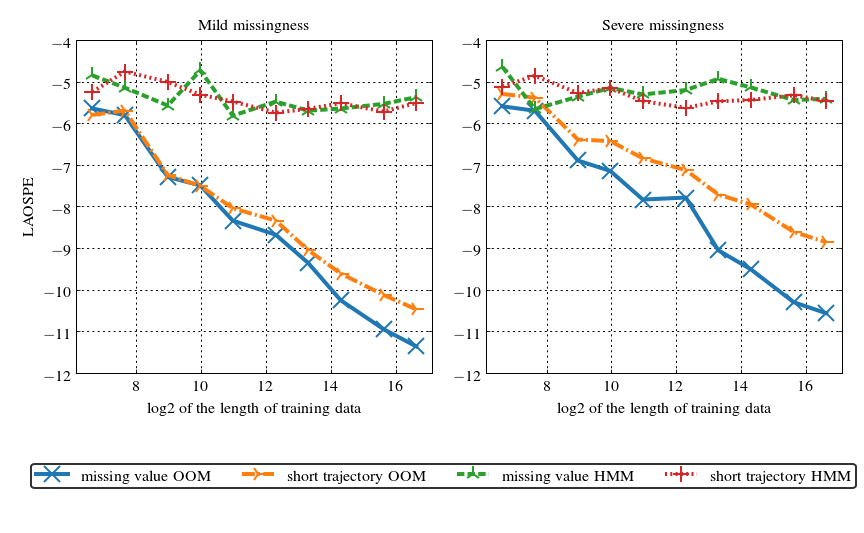

In [55]:
plt.rc('axes', titlesize=8)     # fontsize of the axes title
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels
plt.rc('font', family='serif', serif='Times', weight='bold')
plt.rc('text', usetex=True)

width = 6
height = width / 1.618 / 1.8 



fig = plt.figure()
#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

#plt.subplots_adjust(left=.15, bottom= .16, right=0.99, top=0.97, wspace=0.3, hspace=0.5)
#plt.suptitle('RING TOPOLOGY', fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.5)


ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)




ax1.plot(np.log2(np.array(trainLengths)), 
            np.log2(resultDict['mild_' + 'proposed_averageOneStepPredictionError']), 
            linewidth=2, 
            linestyle='-', 
            marker = 'x',
            markersize=8,
            #label='missing value OOM'
           );

ax1.plot(np.log2(np.array(trainLengths)), 
        np.log2(resultDict['mild_' + 'short_traj_oom_averageOneStepPredictionError']), 
        linewidth=2, 
        marker = '4',
        markersize=8,
        linestyle='-.', 
        #label='short trajectory OOM'
       );

ax1.plot(np.log2(np.array(trainLengths)),  
        np.log2(resultDict['mild_' + 'missing_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle='--', 
        marker = '2',
        markersize=8,
        #label='missing value HMM' 
       );


ax1.plot(np.log2(np.array(trainLengths)),  
        np.log2(resultDict['mild_' + 'short_traj_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle=':', 
        marker = '+',
        markersize=8,
        #label='short trajectory HMM' 
       );



ax1.set_ylabel('LAOSPE');
ax1.set_xlabel('log2 of the length of training data');
ax1.set_ylim(-12, -4)
ax1.set_title('Mild missingness')







######




ax2.plot(np.log2(np.array(trainLengths)), 
            np.log2(resultDict['severe_' + 'proposed_averageOneStepPredictionError']), 
            linewidth=2, 
            linestyle='-', 
            marker = 'x',
            markersize=8,
            label='missing value OOM'
           );

ax2.plot(np.log2(np.array(trainLengths)), 
        np.log2(resultDict['severe_' + 'short_traj_oom_averageOneStepPredictionError']), 
        linewidth=2, 
        marker = '4',
        markersize=8,
        linestyle='-.', 
        label='short trajectory OOM'
       );


ax2.plot(np.log2(np.array(trainLengths)),  
        np.log2(resultDict['severe_' + 'missing_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle='--', 
        marker = '2',
        markersize=8,
        label='missing value HMM' 
       );

ax2.plot(np.log2(np.array(trainLengths)),  
        np.log2(resultDict['severe_' + 'short_traj_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle=':', 
        marker = '+',
        markersize=8,
        label='short trajectory HMM' 
       );




#ax4.set_ylabel('Log of one-step prediction error');
ax2.set_xlabel('log2 of the length of training data');
ax2.set_ylim(-12, -4)

ax2.set_title('Severe missingness')



#ax.tick_params(labelsize=8, rotation=0)
ax2.tick_params(labelsize=8, rotation=0)

#plt.setp(ax.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)



ax1.grid(color='k', linestyle=':', linewidth=0.5)
ax2.grid(color='k', linestyle=':', linewidth=0.5)






box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width, box.height])

# Put a legend to the right of the current axis
#legend = ax4.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.4), ncol=2 ,fontsize='8')
legend = ax2.legend(loc='upper center', bbox_to_anchor=(-0.12, -0.25), ncol= 4 ,fontsize='8')

# Put a nicer background color on the legend.
#legend.get_frame().set_facecolor('0.9')
legend.get_frame().set_edgecolor('k')
#ax2.set_title('Ring topology + mild missingness')

#plt.tight_layout()
#plt.gcf().subplots_adjust(bottom=0.3, top=0.9, left = 0.05)
plt.tight_layout()

plt.gcf().subplots_adjust(bottom=0.3)

fig.set_size_inches(width, height)

# plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MINDS/OOM/missingValueManuscript/fig/ring.png',dpi=1200)
plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MINDS/OOM/missingValueManuscript/fig/ring2.png',dpi=1200)


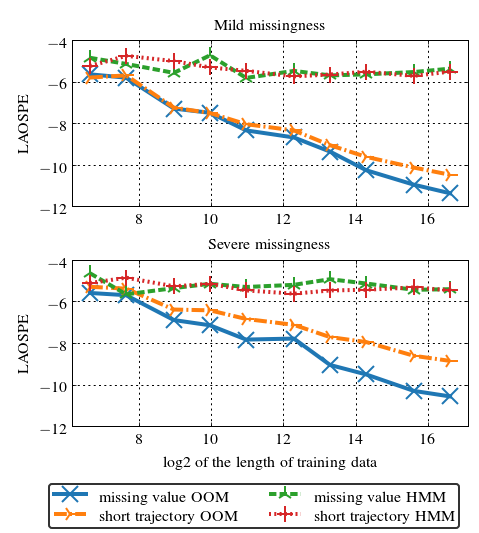

In [81]:
plt.rc('axes', titlesize=8)     # fontsize of the axes title
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels
plt.rc('font', family='serif', serif='Times', weight='bold')
plt.rc('text', usetex=True)

width = 6
height = width / 1.618 
width = width/1.8


fig = plt.figure()
#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

#plt.subplots_adjust(left=.15, bottom= .16, right=0.99, top=0.97, wspace=0.3, hspace=0.5)
#plt.suptitle('RING TOPOLOGY', fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.5)


# ax = fig.add_subplot(222)
# ax2 = fig.add_subplot(224)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)





####



ax1.plot(np.log2(np.array(trainLengths)), 
            np.log2(resultDict['mild_' + 'proposed_averageOneStepPredictionError']), 
            linewidth=2, 
            linestyle='-', 
            marker = 'x',
            markersize=8,
            #label='missing value OOM'
           );

ax1.plot(np.log2(np.array(trainLengths)), 
        np.log2(resultDict['mild_' + 'short_traj_oom_averageOneStepPredictionError']), 
        linewidth=2, 
        marker = '4',
        markersize=8,
        linestyle='-.', 
        #label='short trajectory OOM'
       );

ax1.plot(np.log2(np.array(trainLengths)),  
        np.log2(resultDict['mild_' + 'missing_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle='--', 
        marker = '2',
        markersize=8,
        #label='missing value HMM' 
       );


ax1.plot(np.log2(np.array(trainLengths)),  
        np.log2(resultDict['mild_' + 'short_traj_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle=':', 
        marker = '+',
        markersize=8,
        #label='short trajectory HMM' 
       );



ax1.set_ylabel('LAOSPE');
# ax1.set_xlabel('log2 of the length of training data');
ax1.set_ylim(-12, -4)
ax1.set_title('Mild missingness')







######




ax2.plot(np.log2(np.array(trainLengths)), 
            np.log2(resultDict['severe_' + 'proposed_averageOneStepPredictionError']), 
            linewidth=2, 
            linestyle='-', 
            marker = 'x',
            markersize=8,
            label='missing value OOM'
           );

ax2.plot(np.log2(np.array(trainLengths)), 
        np.log2(resultDict['severe_' + 'short_traj_oom_averageOneStepPredictionError']), 
        linewidth=2, 
        marker = '4',
        markersize=8,
        linestyle='-.', 
        label='short trajectory OOM'
       );


ax2.plot(np.log2(np.array(trainLengths)),  
        np.log2(resultDict['severe_' + 'missing_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle='--', 
        marker = '2',
        markersize=8,
        label='missing value HMM' 
       );

ax2.plot(np.log2(np.array(trainLengths)),  
        np.log2(resultDict['severe_' + 'short_traj_hmm_averageOneStepPredictionError']), 
        linewidth=2, 
        linestyle=':', 
        marker = '+',
        markersize=8,
        label='short trajectory HMM' 
       );




#ax4.set_ylabel('Log of one-step prediction error');
ax2.set_ylabel('LAOSPE');
ax2.set_xlabel('log2 of the length of training data');
ax2.set_ylim(-12, -4)

ax2.set_title('Severe missingness')



#ax.tick_params(labelsize=8, rotation=0)
ax2.tick_params(labelsize=8, rotation=0)

#plt.setp(ax.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)



ax1.grid(color='k', linestyle=':', linewidth=0.5)
ax2.grid(color='k', linestyle=':', linewidth=0.5)






box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width, box.height])

# Put a legend to the right of the current axis
#legend = ax4.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.4), ncol=2 ,fontsize='8')
legend = ax2.legend(loc='upper center', bbox_to_anchor=(0.46, -0.3), ncol= 2 ,fontsize='8')

# Put a nicer background color on the legend.
#legend.get_frame().set_facecolor('0.9')
legend.get_frame().set_edgecolor('k')
#ax2.set_title('Ring topology + mild missingness')

#plt.tight_layout()
# plt.gcf().subplots_adjust(bottom=0.3, top=0.9, left = 0.05)
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.2, left = 0.15)

fig.set_size_inches(width, height)

plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MINDS/OOM/missingValueManuscript/fig/ring2.png',dpi=1200)
